In [49]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import random

import math
import os
from tqdm import tqdm

import seaborn as sns


In [50]:
#Constants
T = 1
S0 = 10
drift = .05
volatility = .2
r = .02

#Using N=5000 and Strike = 10
N = 5000
k = 10

delta_t = T / N

In [51]:
def Q_numeraire_B(delta_t, volatility): 
    q = (1 - np.exp(-1 * volatility * np.sqrt(delta_t))) / (np.exp(volatility * np.sqrt(delta_t)) -np.exp(-1 * volatility * np.sqrt(delta_t)))
    return q

In [52]:
def Q_numeraire_S(delta_t, volatility):
    q = (1 - np.exp(volatility * np.sqrt(delta_t))) / (np.exp(-1 * volatility * np.sqrt(delta_t)) -np.exp(volatility * np.sqrt(delta_t)))
    return q

In [53]:
def generate_RV_value(number_of_random_values = 10):
    #Probability for going up
    p = 0.5 * (1 + (((drift - r) - 0.5 * volatility ** 2) / volatility) * np.sqrt(delta_t) )
    
    #np.random.seed(0)
    random_uniform_valbues = np.random.rand(number_of_random_values)
    steps = np.where(random_uniform_valbues <= p, 1, -1)
    return steps

In [54]:
def generate_path_S(number_of_paths = 5):
    
    steps = np.zeros((number_of_paths, N+1))
    paths = np.zeros((number_of_paths, N+1))
    paths[:,0] = S0
    
    for time_step in range(1, N+1):
        rv = generate_RV_value(number_of_paths) 
        paths[:, time_step] = paths[:, time_step-1] * np.exp(r * delta_t + volatility * np.sqrt(delta_t) * rv)
        steps[:, time_step] = rv

    return paths, steps

In [55]:
#Making trees (rebalancing)
#For B
#Adding 1s as the dimension includes 0. 

def get_tree_B():
    tree_B = np.zeros((N + 1,N + 1))

    #Initialize the initial value that is
    # e^rt at t=0 is 1

    tree_B[0,0] = 1
    #For columns
    for j in range(1, tree_B.shape[1]):
        #For rows
        for i in range(j + 1):
            if i - 1 < 0:
                tree_B[i, j] = tree_B[i, j-1] * np.exp(r * delta_t)

            else:
                tree_B[i, j] = tree_B[i-1, j-1] * np.exp(r * delta_t)
    
    return tree_B

In [56]:
def get_tree_S():
    tree_S = np.zeros((N + 1,N + 1))

    #Initialize the initial value that is
    tree_S[0,0] = S0

    #For columns
    for j in range(1, tree_S.shape[1]):
        #For rows
        for i in range(j + 1):
            #If row 0
            if i - 1 < 0:
                #Up
                tree_S[i, j] = tree_S[i, j-1] * np.exp(r * delta_t + volatility*np.sqrt(delta_t))

            else:
                #Down
                tree_S[i, j] = tree_S[i-1, j-1] * np.exp(r * delta_t - volatility*np.sqrt(delta_t))
                
    return tree_S

In [57]:
#Tree for relative prices with B as numeraire

In [58]:
def put_tree_B_numeraire():
    put = np.zeros((N + 1,N + 1))
    put[:, -1] = np.maximum(k - tree_S[:,-1], 0)
    pd.DataFrame(put)

    q = Q_numeraire_B(delta_t, volatility)

    #Initialize exercise array
    #exercise_array = np.zeros((N+1, N+1))
    #exercise_array[:, -1] = 1
    ls = []

    bo = False
    #Loops are simply reversed
    for j in range(put.shape[1]-1, 0, -1):
        for i in range(j, 0, -1):

            #This doesnt work. Why?
            vhold = tree_B[i-1, j-1] * (q * put[i-1,j] / tree_B[i-1,j] + (1-q) * put[i,j] / tree_B[i,j])
            #vhold = np.exp(-r*delta_t) * (q * put[i-1,j] + (1-q) * put[i,j])

            # if vhold != vhold2:
            #     print("YES")

            #No q was used here to find vexercise, therefore dont get relative value of option,
            #Instead we get the absolute value, which is what we need
            vexercise = max(k - tree_S[i-1, j-1], 0)

            put[i-1, j-1] = max(vhold, vexercise)

            #Dealing with exercise_array
            if vexercise > vhold:
                #exercise_array[i-1, j-1] = 1
                ls.append((j-1, tree_S[i-1, j-1]))
    return put, ls

In [59]:
def put_tree_S_numeraire():
    put = np.zeros((N + 1,N + 1))
    put[:, -1] = np.maximum(k - tree_S[:,-1], 0)
    pd.DataFrame(put)

    q = Q_numeraire_S(delta_t, volatility)

    #Initialize exercise array
    #exercise_array = np.zeros((N+1, N+1))
    #exercise_array[:, -1] = 1
    ls = []

    bo = False
    #Loops are simply reversed
    for j in range(put.shape[1]-1, 0, -1):
        for i in range(j, 0, -1):

            vhold = tree_S[i-1, j-1] * (q * put[i-1,j] / tree_S[i-1,j] + (1-q) * put[i,j] / tree_S[i,j])

            #No q was used here to find vexercise, therefore dont get relative value of option,
            #Instead we get the absolute value, which is what we need
            vexercise = max(k - tree_S[i-1, j-1], 0)

            put[i-1, j-1] = max(vhold, vexercise)

            #Dealing with exercise_array
            if vexercise > vhold:
                #exercise_array[i-1, j-1] = 1
                ls.append((j-1, tree_S[i-1, j-1]))
                
    return put, ls    

In [60]:
def exercise_boundary_generator(ls):
    #Gets the exercise boundary for the put
    A = pd.DataFrame(ls, columns=['t', 'S'])
    A = A.groupby('t')['S'].max().reset_index()
    return np.array(A)

In [61]:
def get_finalized_path(exercised_path, exercise_boundary):
    A = pd.DataFrame(exercise_boundary)
    A.index = A[0].astype(int)
    A = A.drop(columns=0)

    B = pd.DataFrame(exercised_path)
    df = pd.merge(B, A, left_index=True, right_index=True, how='inner')
    mask = df[0] <= df[1]
    #display(df.loc[mask])
    
    if df.loc[mask].shape[0] == 0:
        #print(1)
        return exercised_path
    else:
        time_to_exercise = df.loc[mask].sort_index().index[0]
        #print(time_to_exercise)
        exercised_path = exercised_path[:time_to_exercise+1]
        return exercised_path

In [62]:
def generate_path_S_given_steps(steps):
    
    path = np.zeros(N+1)
    path[0] = S0
    
    for time_step in range(1, N+1):
        path[time_step] = path[time_step-1] * np.exp(r * delta_t + volatility * np.sqrt(delta_t) * steps[time_step])
    return path

In [63]:
def generate_alpha_tree(S_as_numeraire, tree_S):
    alpha_tree = np.zeros((N + 1,N + 1))
    for j in range(1, N+1):
        for i in range(j):
            alpha_tree[i ,j-1] = (S_as_numeraire[i,j] - S_as_numeraire[i+1,j]) / (tree_S[i,j] - tree_S[i+1,j])
    
    return alpha_tree

In [64]:
def generate_beta_tree(S_as_numeraire):
    beta_tree = np.zeros((N + 1,N + 1))
    for j in range(1, N+1):
        for i in range(j):
            up = S_as_numeraire[i,j]
            down = S_as_numeraire[i+1,j]
            fraction_term = (up - down) / (np.exp(volatility * np.sqrt(delta_t)) - np.exp(-volatility * np.sqrt(delta_t)))
            beta_tree[i ,j-1] = np.exp(-r * delta_t) * (fraction_term * np.exp(volatility * np.sqrt(delta_t)) - up)
    
    return beta_tree

In [65]:
def traverse_alpha_beta_trees(path_steps, alpha_tree, beta_tree):
    alpha_for_path = np.zeros(N+1)
    alpha_for_path[0] = alpha_tree[0][0]
    beta_for_path = np.zeros(N+1)
    beta_for_path[0] = beta_tree[0][0]

    x, y = 0, 0
    for i in range(1, N+1):
        y = y + 1
        if path_steps[i] == 1:
            alpha_for_path[i] = alpha_tree[x, y]
            beta_for_path[i] = beta_tree[x, y]
        else:
            x = x + 1
            alpha_for_path[i] = alpha_tree[x, y]
            beta_for_path[i] = beta_tree[x, y]
            
    return alpha_for_path[:-1], beta_for_path[:-1]

In [66]:
tree_B = get_tree_B()
tree_S = get_tree_S()

In [67]:
S_as_numeraire, S_exercise_points = put_tree_S_numeraire()

In [68]:
B_as_numeraire, B_exercise_points = put_tree_B_numeraire()

In [69]:
exercise_boundary = exercise_boundary_generator(S_exercise_points)
exercise_boundary_B = exercise_boundary_generator(B_exercise_points)

In [70]:
np.random.seed(112)
paths, steps = generate_path_S(100)

In [71]:
exercised_early_path = get_finalized_path(paths[6], exercise_boundary)
exercised_never_path = get_finalized_path(paths[10], exercise_boundary)

exercised_early_path_B = get_finalized_path(paths[6], exercise_boundary_B)
exercised_never_path_B = get_finalized_path(paths[10], exercise_boundary_B)

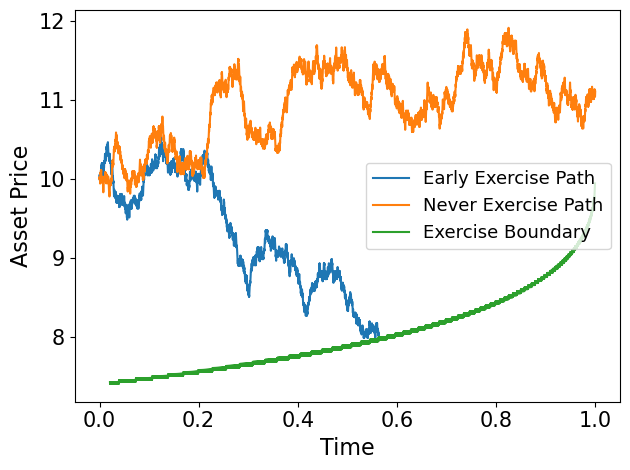

In [24]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=13)
plt.plot(np.linspace(0,exercised_early_path.shape[0], exercised_early_path.shape[0]) * delta_t, exercised_early_path, label='Early Exercise Path')
plt.plot(np.linspace(0,exercised_never_path.shape[0], exercised_never_path.shape[0]) * delta_t, exercised_never_path, label='Never Exercise Path')
plt.plot(exercise_boundary[:,0] * delta_t, exercise_boundary[:, 1], label='Exercise Boundary')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Asset Price', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig("twopath.pdf")

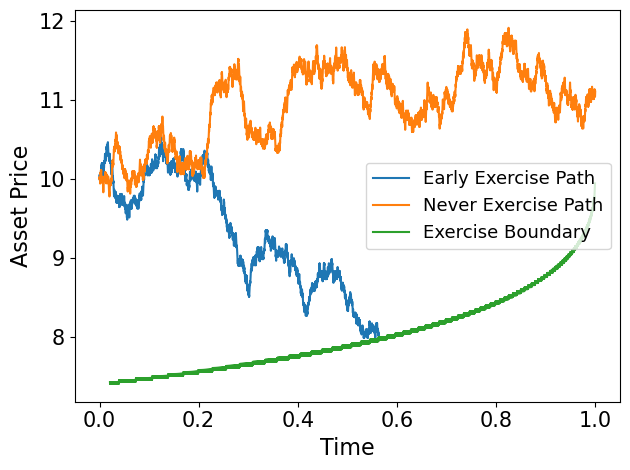

In [25]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('legend', fontsize=13)
plt.plot(np.linspace(0,exercised_early_path_B.shape[0], exercised_early_path_B.shape[0]) * delta_t, exercised_early_path_B, label='Early Exercise Path')
plt.plot(np.linspace(0,exercised_never_path_B.shape[0], exercised_never_path_B.shape[0]) * delta_t, exercised_never_path_B, label='Never Exercise Path')
plt.plot(exercise_boundary_B[:,0] * delta_t, exercise_boundary_B[:, 1], label='Exercise Boundary')
plt.xlabel('Time', fontsize=16)
plt.ylabel('Asset Price', fontsize=16)
plt.legend()
plt.tight_layout()
plt.savefig("twopath_B.pdf")

In [26]:
alpha_tree = generate_alpha_tree(S_as_numeraire, tree_S)
beta_tree = generate_beta_tree(S_as_numeraire)

In [27]:
alpha_early_exercise, beta_early_exercise = traverse_alpha_beta_trees(steps[6], alpha_tree, beta_tree)
alpha_early_exercise = alpha_early_exercise[:exercised_early_path.shape[0]]
beta_early_exercise = beta_early_exercise[:exercised_early_path.shape[0]]
alpha_never_exercise, beta_never_exercise = traverse_alpha_beta_trees(steps[10], alpha_tree, beta_tree)

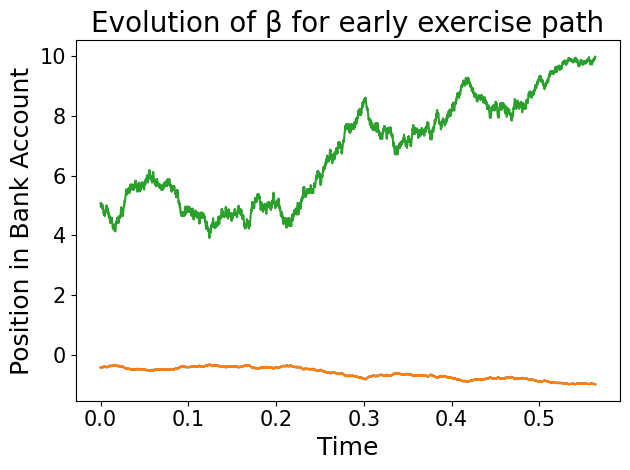

In [74]:
#Early Exercise plots
plt.plot(np.linspace(0,alpha_early_exercise.shape[0], alpha_early_exercise.shape[0]) * delta_t, alpha_early_exercise, label='Early Exercise Path')
plt.ylabel('Position in Asset S', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Evolution of α for early exercise path', fontsize=20)
plt.tight_layout()
plt.savefig("alphaexercisepath.pdf")


plt.plot(np.linspace(0,beta_early_exercise.shape[0], beta_early_exercise.shape[0]) * delta_t, -1 * beta_early_exercise, label='Early Exercise Path')
plt.ylabel('Position in Bank Account', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Evolution of β for early exercise path', fontsize=20)
plt.tight_layout()
plt.savefig("betaexercisepath.pdf")


In [ ]:
#Non Exercise plots
plt.plot(np.linspace(0,alpha_never_exercise.shape[0], alpha_never_exercise.shape[0]) * delta_t, alpha_never_exercise, label='Early Exercise Path')
plt.ylabel('Position in Asset S', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Evolution of α for non-exercise path', fontsize=20)
plt.tight_layout()
plt.savefig("alphanotexercisepath.pdf")

plt.plot(np.linspace(0,beta_never_exercise.shape[0], beta_never_exercise.shape[0]) * delta_t, -1 * beta_never_exercise, label='Early Exercise Path')
plt.ylabel('Position in Bank Account', fontsize=18)
plt.xlabel('Time', fontsize=18)
plt.title('Evolution of β for non-exercise path', fontsize=20)
plt.tight_layout()
plt.savefig("betanotexercisepath.pdf")

### Q2 Part 4

In [82]:
r = 0
for volatility in [0.1, 0.2, 0.3]:
    #Make the trees
    tree_B = get_tree_B()
    tree_S = get_tree_S()
    
    S_as_numeraire, S_exercise_points = put_tree_S_numeraire()
    B_as_numeraire, B_exercise_points = put_tree_B_numeraire()
    #exercise_boundary = exercise_boundary_generator(S_exercise_points)
    
    np.random.seed(112)
    paths, steps = generate_path_S(100)
    
    #exercised_early_path = get_finalized_path(paths[6], exercise_boundary)
    exercised_never_path = get_finalized_path(paths[10], exercise_boundary)
    

    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('legend', fontsize=20)

    #plt.plot(np.linspace(0,exercised_early_path.shape[0], exercised_early_path.shape[0]) * delta_t, exercised_early_path, label='Early Exercise Path')
    plt.plot(np.linspace(0,exercised_never_path.shape[0], exercised_never_path.shape[0]) * delta_t, exercised_never_path, label='Never Exercise Path')
    #plt.plot(exercise_boundary[:,0] * delta_t, exercise_boundary[:, 1], label='Exercise Boundary')
    plt.ylim(5.5,13)
    plt.xlabel('Time', fontsize=22)
    plt.ylabel('Asset Price', fontsize=22)
    plt.title('r = ' + str(r) + ',  σ = ' + str(volatility), fontsize=24)
    plt.legend()
    plt.tight_layout()
    plt.savefig("r" + str(r) + "vol" + str(volatility) + "boundary.pdf")
    plt.clf()

    alpha_tree = generate_alpha_tree(S_as_numeraire, tree_S)
    beta_tree = generate_beta_tree(S_as_numeraire)
    
    #alpha_early_exercise, beta_early_exercise = traverse_alpha_beta_trees(steps[6], alpha_tree, beta_tree)
    #alpha_early_exercise = alpha_early_exercise[:exercised_early_path.shape[0]]
    #beta_early_exercise = beta_early_exercise[:exercised_early_path.shape[0]]
    alpha_never_exercise, beta_never_exercise = traverse_alpha_beta_trees(steps[10], alpha_tree, beta_tree)

    plt.plot(np.linspace(0,alpha_never_exercise.shape[0], alpha_never_exercise.shape[0]) * delta_t, alpha_never_exercise, label='Early Exercise Path')
    plt.ylim(-0.55,0.05)
    plt.ylabel('Position in Asset S', fontsize=24)
    plt.xlabel('Time', fontsize=24)
    plt.title('α for non-exercise, r='+ str(r) + ', σ=' + str(volatility), fontsize=24)
    plt.tight_layout()
    plt.savefig("alphanotexercisepath" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
    plt.clf()

    plt.plot(np.linspace(0,beta_never_exercise.shape[0], beta_never_exercise.shape[0]) * delta_t, -1 * beta_never_exercise, label='Early Exercise Path')
    plt.ylim(-0.5,6.5)
    plt.ylabel('Position in Bank Account', fontsize=24)
    plt.xlabel('Time', fontsize=24)
    plt.title('β for non-exercise, r='+ str(r) + ', σ=' + str(volatility), fontsize=24)
    plt.tight_layout()
    plt.savefig("betanotexercisepath" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
    plt.clf()

<Figure size 640x480 with 0 Axes>

In [87]:
for r in [0.02, 0.04]:
    for volatility in [0.1, 0.2, 0.3]:
        #Make the trees
        tree_B = get_tree_B()
        tree_S = get_tree_S()
        
        S_as_numeraire, S_exercise_points = put_tree_S_numeraire()
        B_as_numeraire, B_exercise_points = put_tree_B_numeraire()
        exercise_boundary = exercise_boundary_generator(S_exercise_points)
        
        np.random.seed(112)
        paths, steps = generate_path_S(100)
        
        exercised_early_path = get_finalized_path(paths[6], exercise_boundary)
        exercised_never_path = get_finalized_path(paths[10], exercise_boundary)

        plt.rc('xtick', labelsize=18)
        plt.rc('ytick', labelsize=18)
        plt.rc('legend', fontsize=16)
        
        plt.plot(np.linspace(0,exercised_early_path.shape[0], exercised_early_path.shape[0]) * delta_t, exercised_early_path, label='Early Exercise Path')
        plt.plot(np.linspace(0,exercised_never_path.shape[0], exercised_never_path.shape[0]) * delta_t, exercised_never_path, label='Never Exercise Path')
        plt.plot(exercise_boundary[:,0] * delta_t, exercise_boundary[:, 1], label='Exercise Boundary')
        plt.ylim(5.5,13)
        plt.xlabel('Time', fontsize=22)
        plt.ylabel('Asset Price', fontsize=22)
        plt.title('r = ' + str(r) + ',  σ = ' + str(volatility), fontsize=24)
        plt.legend()
        plt.tight_layout()
        plt.savefig("r" + str(r) + "vol" + str(volatility) + "boundary.pdf")
        plt.clf()

        alpha_tree = generate_alpha_tree(S_as_numeraire, tree_S)
        beta_tree = generate_beta_tree(S_as_numeraire)
        
        alpha_early_exercise, beta_early_exercise = traverse_alpha_beta_trees(steps[6], alpha_tree, beta_tree)
        alpha_early_exercise = alpha_early_exercise[:exercised_early_path.shape[0]]
        beta_early_exercise = beta_early_exercise[:exercised_early_path.shape[0]]
        alpha_never_exercise, beta_never_exercise = traverse_alpha_beta_trees(steps[10], alpha_tree, beta_tree)

        plt.plot(np.linspace(0,alpha_early_exercise.shape[0], alpha_early_exercise.shape[0]) * delta_t, alpha_early_exercise, label='Early Exercise Path')
        plt.xlim(-0.03,0.63)
        plt.ylim(-1.05,-0.2)
        plt.ylabel('Position in Asset S', fontsize=18)
        plt.xlabel('Time', fontsize=18)
        plt.title('α for early exercise, r='+ str(r) + ', σ=' + str(volatility), fontsize=20)
        plt.tight_layout()
        plt.savefig("alphaexercisepath" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
        plt.clf()


        plt.plot(np.linspace(0,beta_early_exercise.shape[0], beta_early_exercise.shape[0]) * delta_t, -1 * beta_early_exercise, label='Early Exercise Path')
        plt.xlim(-0.03,0.63)
        plt.ylim(2.5,10.5)
        plt.ylabel('Position in Bank Account', fontsize=18)
        plt.xlabel('Time', fontsize=18)
        plt.title('β for early exercise, r='+ str(r) + ', σ=' + str(volatility), fontsize=20)
        plt.tight_layout()
        plt.savefig("betaexercisepath" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
        plt.clf()

        plt.plot(np.linspace(0,alpha_never_exercise.shape[0], alpha_never_exercise.shape[0]) * delta_t, alpha_never_exercise, label='Early Exercise Path')
        plt.ylim(-0.55,0.05)
        plt.ylabel('Position in Asset S', fontsize=24)
        plt.xlabel('Time', fontsize=24)
        plt.title('α for non-exercise, r='+ str(r) + ', σ=' + str(volatility), fontsize=22)
        plt.tight_layout()
        plt.savefig("alphanotexercisepath" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
        plt.clf()

        plt.plot(np.linspace(0,beta_never_exercise.shape[0], beta_never_exercise.shape[0]) * delta_t, -1 * beta_never_exercise, label='Early Exercise Path')
        plt.ylim(-0.5,6.5)
        plt.ylabel('Position in Bank Account', fontsize=24)
        plt.xlabel('Time', fontsize=24)
        plt.title('β for non-exercise, r='+ str(r) + ', σ=' + str(volatility), fontsize=24)
        plt.tight_layout()
        plt.savefig("betanotexercisepath" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
        plt.clf()
        

<Figure size 640x480 with 0 Axes>

### Question 3

In [26]:
#Constants
T = 1
S0 = 10
drift = .05
volatility = .2
r = .02

#Using N=5000 and Strike = 10
N = 5000
k = 10

delta_t = T / N

number_of_sample_paths = 1000

In [27]:
stopping_time = []
profit_list = []

q3_paths, q3_steps = generate_path_S(number_of_sample_paths)

for i in range(q3_paths.shape[0]):
    f_path = get_finalized_path(q3_paths[i], exercise_boundary)
    exercise_t = f_path.shape[0]
    
    if exercise_t >= 4998:
        continue
    else:
        value_of_option = np.exp(-r * exercise_t / N) * np.maximum(k - f_path[-1], 0)
        
    profit = value_of_option - B_as_numeraire[0][0]
    profit_list.append(profit)
    stopping_time.append(exercise_t / N)

c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

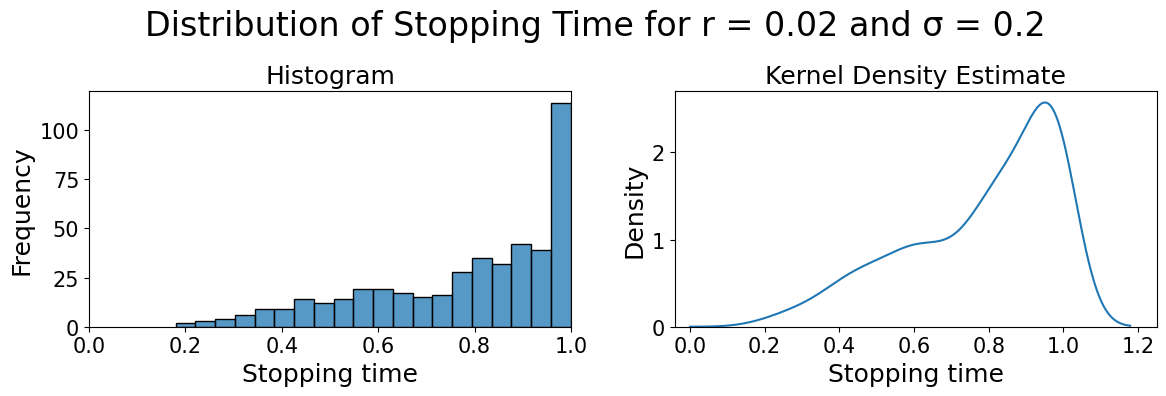

In [44]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(stopping_time, kde=False, bins=20)
plt.xlim(0,1)
plt.suptitle('Distribution of Stopping Time for r = ' + str(r) + ' and σ = ' + str(volatility),fontsize=24)
plt.ylabel('Frequency',fontsize=18)
plt.xlabel('Stopping time',fontsize=18)
plt.title('Histogram',fontsize=18)
plt.subplot(1, 2, 2)
sns.kdeplot(stopping_time)
plt.xlim(-0.04, 1.25)
plt.ylabel('Density',fontsize=18)
plt.xlabel('Stopping time',fontsize=18)
plt.title('Kernel Density Estimate',fontsize=18)
plt.tight_layout()
plt.savefig("pnl" + "r" + str(r) + "vol" + str(volatility) + ".pdf")

c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

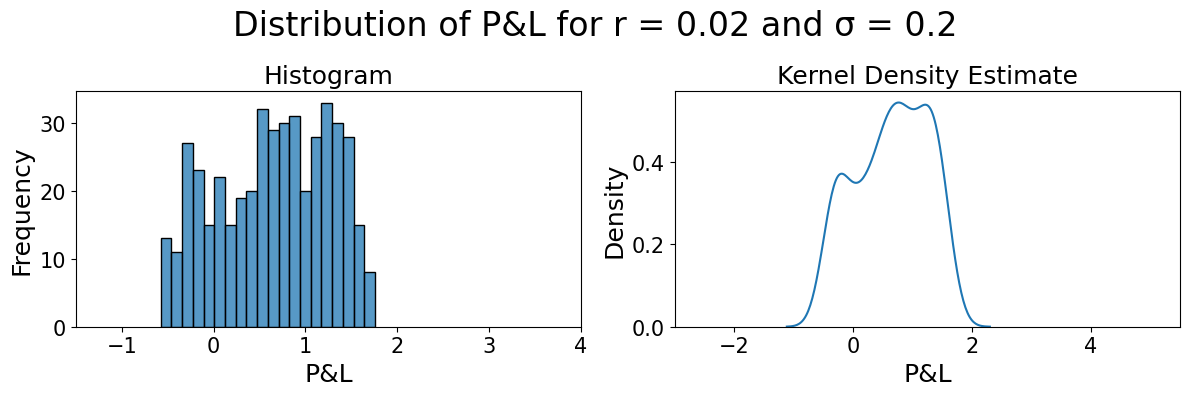

In [45]:
#plt.hist(profit_list, bins=20)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
sns.histplot(profit_list, kde=False, bins=20)
plt.xlim(-1.5,4)
plt.suptitle('Distribution of P&L for r = ' + str(r) + ' and σ = ' + str(volatility),fontsize=24)
plt.ylabel('Frequency',fontsize=18)
plt.xlabel('P&L',fontsize=18)
plt.title('Histogram',fontsize=18)
plt.subplot(1, 2, 2)
sns.kdeplot(profit_list)
plt.xlim(-3,5.5)
plt.ylabel('Density',fontsize=18)
plt.xlabel('P&L',fontsize=18)
plt.title('Kernel Density Estimate',fontsize=18)
plt.tight_layout()
plt.savefig("stoptime" + "r" + str(r) + "vol" + str(volatility) + ".pdf")

In [43]:
print(len(stopping_time) / number_of_sample_paths, 'is the probability of exercising')

0.449 is the probability of exercising


### Q3 b)

In [48]:
for r in [.01, .03, .05]:
    for volatility in [.1, .3, .5]:
        
        tree_B = get_tree_B()
        tree_S = get_tree_S()
        
        S_as_numeraire, S_exercise_points = put_tree_S_numeraire()
        #B_as_numeraire, B_exercise_points = put_tree_B_numeraire()
        exercise_boundary = exercise_boundary_generator(S_exercise_points)
        
        #
        stopping_time = []
        profit_list = []

        q3_paths, q3_steps = generate_path_S(number_of_sample_paths)

        for i in range(q3_paths.shape[0]):
            f_path = get_finalized_path(q3_paths[i], exercise_boundary)
            exercise_t = f_path.shape[0]

            if exercise_t >= 4998:
                continue
            else:
                value_of_option = np.exp(-r * exercise_t / N) * np.maximum(k - f_path[-1], 0)

            profit = value_of_option - S_as_numeraire[0][0]
            profit_list.append(profit)
            stopping_time.append(exercise_t / N)
            
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(stopping_time, kde=False, bins=20)
        plt.suptitle('Distribution of Stopping Time for r = ' + str(r) + ' and σ = ' + str(volatility),fontsize=24)
        plt.xlim(0,1)
        plt.ylabel('Frequency',fontsize=18)
        plt.xlabel('Stopping time',fontsize=18)
        plt.title('Histogram',fontsize=18)
        plt.subplot(1, 2, 2)
        sns.kdeplot(stopping_time)
        plt.xlim(-0.04, 1.25)
        plt.ylabel('Density',fontsize=18)
        plt.xlabel('Stopping time',fontsize=18)
        plt.title('Kernel Density Estimate',fontsize=18)
        plt.tight_layout()
        plt.savefig("stoptime" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
        plt.clf()

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(profit_list, kde=False, bins=20)
        plt.suptitle('Distribution of P&L for r = ' + str(r) + ' and σ = ' + str(volatility),fontsize=24)
        plt.xlim(-1.5,4)
        plt.ylabel('Frequency',fontsize=18)
        plt.xlabel('P&L',fontsize=18)
        plt.title('Histogram',fontsize=18)
        plt.subplot(1, 2, 2)
        sns.kdeplot(profit_list)
        plt.xlim(-3,5.5)
        plt.ylabel('Density',fontsize=18)
        plt.xlabel('P&L',fontsize=18)
        plt.title('Kernel Density Estimate',fontsize=18)
        plt.tight_layout()
        plt.savefig("pnl" + "r" + str(r) + "vol" + str(volatility) + ".pdf")
        plt.clf()
        
        print(len(stopping_time) / number_of_sample_paths, 'is the probability of exercising for r = ' + str(r) + ' and sigma = ' + str(volatility))

c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.313 is the probability of exercising for r = 0.01 and sigma = 0.1


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.45 is the probability of exercising for r = 0.01 and sigma = 0.3


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.543 is the probability of exercising for r = 0.01 and sigma = 0.5


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.341 is the probability of exercising for r = 0.03 and sigma = 0.1


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.454 is the probability of exercising for r = 0.03 and sigma = 0.3


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.567 is the probability of exercising for r = 0.03 and sigma = 0.5


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.417 is the probability of exercising for r = 0.05 and sigma = 0.1


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.495 is the probability of exercising for r = 0.05 and sigma = 0.3


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.518 is the probability of exercising for r = 0.05 and sigma = 0.5


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

### Q3) C 
Make Sure to reset the constants and generate trees on those default values

In [74]:
for volatility in [.1, .15, .20, .25, .30]:

    stopping_time = []
    profit_list = []

    q3_paths, q3_steps = generate_path_S(number_of_sample_paths)

    for i in range(q3_paths.shape[0]):
        f_path = get_finalized_path(q3_paths[i], exercise_boundary)
        exercise_t = f_path.shape[0]

        if exercise_t >= 4998:
            continue
        else:
            value_of_option = np.exp(-r * exercise_t / N) * np.maximum(k - f_path[-1], 0)

        profit = value_of_option - S_as_numeraire[0][0]
        profit_list.append(profit)
        stopping_time.append(exercise_t / N)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(stopping_time, kde=False, bins=20)
    plt.suptitle('Distribution of Stopping Time for r = ' + str(r) + ' and σ = ' + str(volatility),fontsize=24)
    plt.xlim(0,1)
    plt.ylabel('Frequency',fontsize=18)
    plt.xlabel('Stopping time',fontsize=18)
    plt.title('Histogram',fontsize=18)
    plt.subplot(1, 2, 2)
    sns.kdeplot(stopping_time)
    plt.xlim(-0.04, 1.25)
    plt.ylabel('Density',fontsize=18)
    plt.xlabel('Stopping time',fontsize=18)
    plt.title('Kernel Density Estimate',fontsize=18)
    plt.tight_layout()
    plt.savefig("mmstoptimevol" + str(volatility) + ".pdf")
    plt.clf()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(profit_list, kde=False, bins=20)
    plt.suptitle('Distribution of P&L for r = ' + str(r) + ' and σ = ' + str(volatility),fontsize=24)
    plt.xlim(-0.7,2)
    plt.ylabel('Frequency',fontsize=18)
    plt.xlabel('P&L',fontsize=18)
    plt.title('Histogram',fontsize=18)
    plt.subplot(1, 2, 2)
    sns.kdeplot(profit_list)
    plt.xlim(-1.3,2.5)
    plt.ylabel('Density',fontsize=18)
    plt.xlabel('P&L',fontsize=18)
    plt.title('Kernel Density Estimate',fontsize=18)
    plt.tight_layout()
    plt.savefig("mmpnlvol" + str(volatility) + ".pdf")
    plt.clf()

    print(len(stopping_time) / number_of_sample_paths, 'is the probability of exercising for r = ' + str(r) + ' and sigma = ' + str(volatility))

c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.272 is the probability of exercising for r = 0.02 and sigma = 0.1


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.375 is the probability of exercising for r = 0.02 and sigma = 0.15


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.424 is the probability of exercising for r = 0.02 and sigma = 0.2


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.503 is the probability of exercising for r = 0.02 and sigma = 0.25


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.

0.532 is the probability of exercising for r = 0.02 and sigma = 0.3


c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\s2007\anaconda3\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>